In [23]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random
import torch

from sklearn.model_selection import train_test_split

In [24]:
df_train = pd.read_csv('ArbuzTrain.csv')
df_test = pd.read_csv('ArbuzTest.csv')

# df_train['average_score'] = df_train['average_score'].fillna(np.mean(df_train['average_score']))
# df_train['last_check'] = df_train['last_check'].fillna(np.mean(df_train['last_check']))
# df_train['last_score'] = df_train['last_score'].fillna(np.mean(df_train['last_score']))
# df_train['last_scored_after_order_days'] = df_train['last_scored_after_order_days'].fillna(np.mean(df_train['last_scored_after_order_days']))

# df_test['average_score'] = df_test['average_score'].fillna(np.mean(df_test['average_score']))
# df_test['last_check'] = df_test['last_check'].fillna(np.mean(df_test['last_check']))
# df_test['last_score'] = df_test['last_score'].fillna(np.mean(df_test['last_score']))
# df_test['last_scored_after_order_days'] = df_test['last_scored_after_order_days'].fillna(np.mean(df_test['last_scored_after_order_days']))
# df_train

### Checking which columns contain NaN values

In [25]:
nan_cols = [i for i in df_train.columns if df_train[i].isnull().any()]
nan_cols

['average_score', 'last_check', 'last_score', 'last_scored_after_order_days']

In [26]:
items_share_category = ['items_share_category_1',
       'items_share_category_2', 'items_share_category_3',
       'items_share_category_5', 'items_share_category_4',
       'items_share_category_6', 'items_share_category_7',
       'items_share_category_8', 'items_share_category_9',
       'items_share_category_10', 'items_share_category_11',
       'items_share_category_12', 'items_share_category_13',
       'items_share_category_14', 'items_share_category_15',
       'items_share_category_16', 'items_share_category_17',
       'items_share_category_18', 'items_share_category_19',
       'items_share_category_20', 'items_share_category_21',
       'items_share_category_22', 'items_share_category_23',
       'items_share_category_24', 'items_share_category_25',
       'items_share_category_26', 'items_share_category_27'] 

In [27]:
def find_max_category(df):
    max_cat = []
    for j in range(len(df)):
        cat_list = []
        for i in range(1,28):
            cat_list.append(df[f'items_share_category_{i}'][j])
        max_cat.append(max(cat_list))
    return max_cat


def prepare_data(data):
    from sklearn.linear_model import LinearRegression
    
    data['last_scored_after_order_days'].fillna(data['last_scored_after_order_days'].median(), inplace = True)
    data['average_score'].fillna(data['average_score'].mean(), inplace = True) #we can use median
    
    n = data.shape[0]
    for i in range(n):
        if np.isnan(data['last_check'][i]):
            x = data.at[i, 'average_check']
            data['last_check'][i] = x
        
        if np.isnan(data['last_score'][i]):
            y = data.at[i, 'average_score']
            data['last_score'][i] = y
            
    return data

### Feature Engineering

In [28]:
#keeping the values 
df_train = df_train[df_train['last_check']>0].reset_index(drop=True)
df_train = df_train.drop(columns = ['client_id'])

test_ids = df_test['client_id']
test = df_test.drop(columns = ['client_id'])

#df_train = prepare_data(df_train)
#test = prepare_data(test)

#df_train['max_cat'] = find_max_category(df_train)
#df_train = df_train.drop(columns = items_share_category)

#test['max_cat'] = find_max_category(test)
#test = test.drop(columns = items_share_category)

numeric_cols = ['average_check', 'number_orders', 'average_score', 'items_per_order', 'last_check', 'last_score', 'last_scored_after_order_days']


X = df_train.drop(columns = ['is_churn'])#, 'average_score', 'last_score', 'last_scored_after_order_days',])
y = df_train['is_churn']

### Handling NaN Values with XGBRegressor imputer

In [29]:
from sklearn.experimental import enable_iterative_imputer # noqa
from sklearn.impute import IterativeImputer
import xgboost as xgb

iim=IterativeImputer(estimator=xgb.XGBRegressor(),
initial_strategy='median',
max_iter=10,
missing_values=np.nan,
skip_complete=True)

imputed_df = pd.DataFrame(iim.fit_transform(X))

imputed_df.columns = X.columns
X=imputed_df

imputed_df_test = pd.DataFrame(iim.fit_transform(test))

imputed_df_test.columns = test.columns
test=imputed_df_test

/opt/anaconda3/lib/python3.8/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Analysis

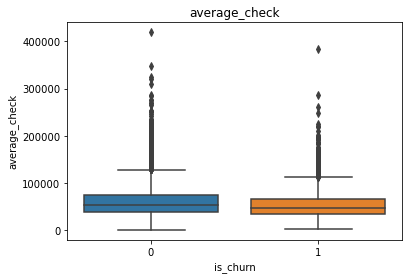

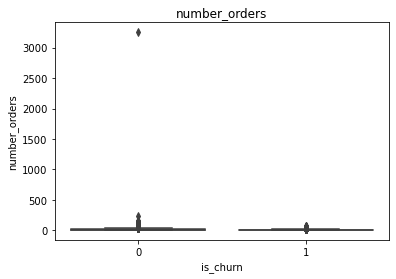

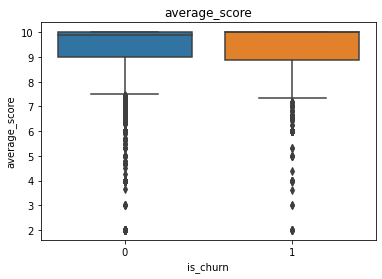

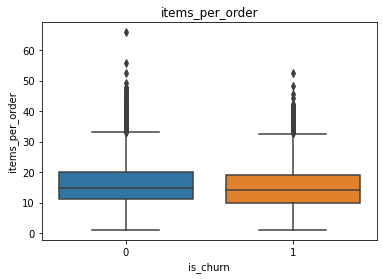

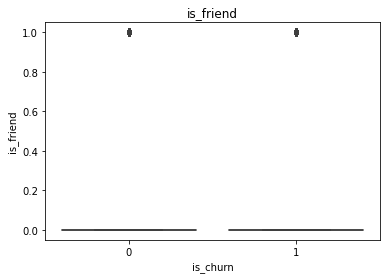

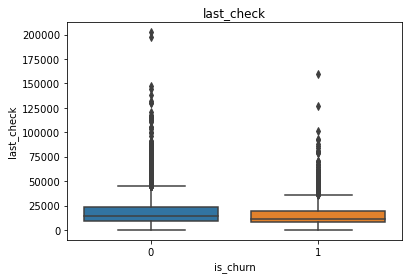

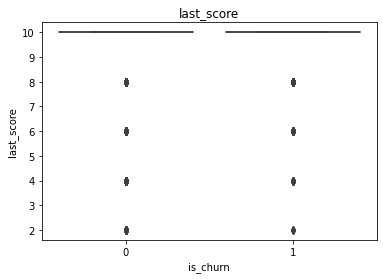

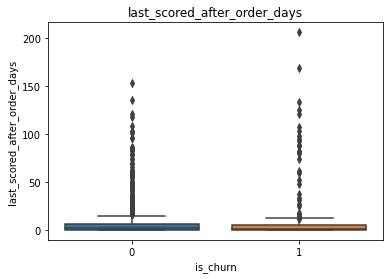

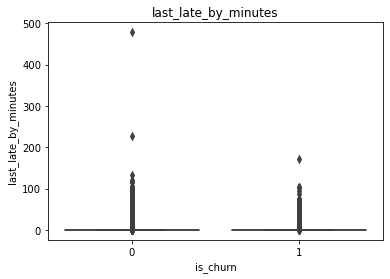

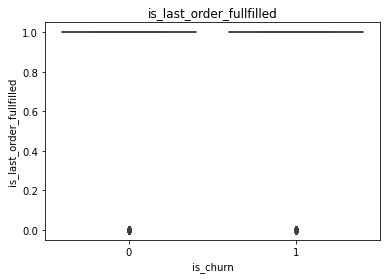

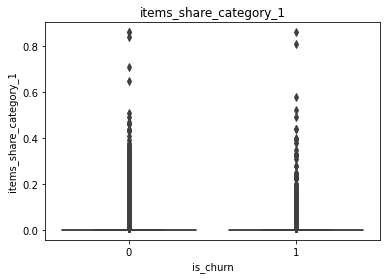

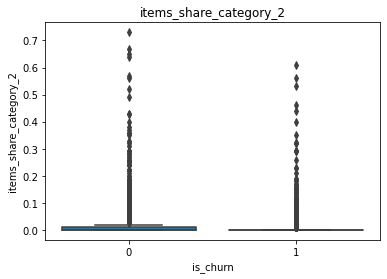

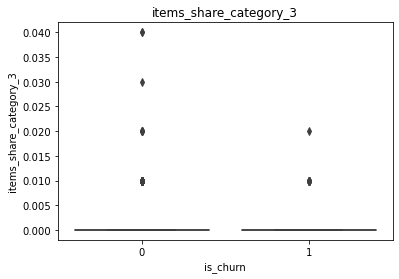

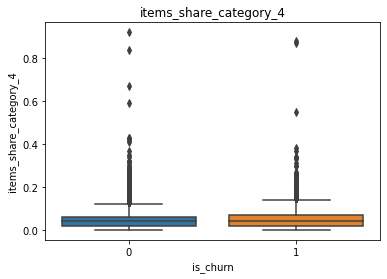

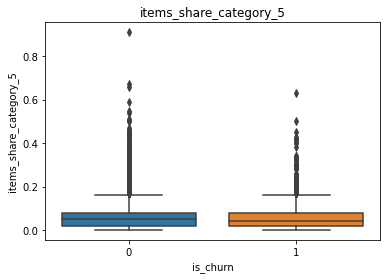

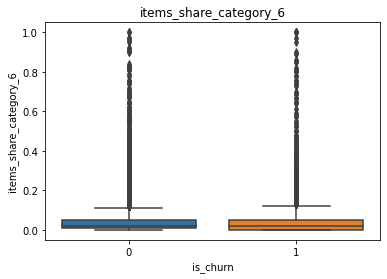

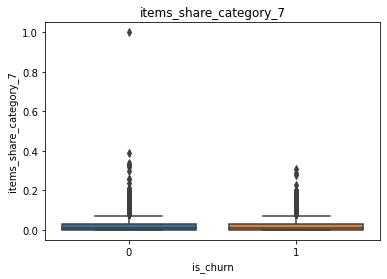

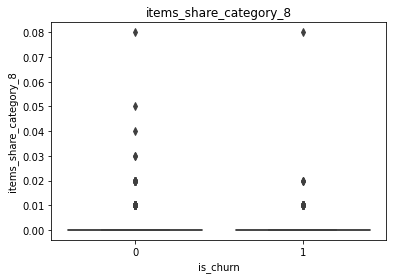

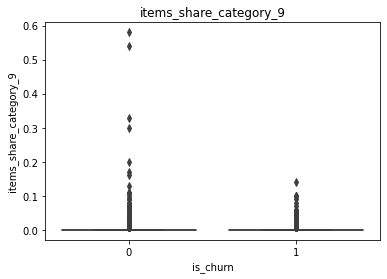

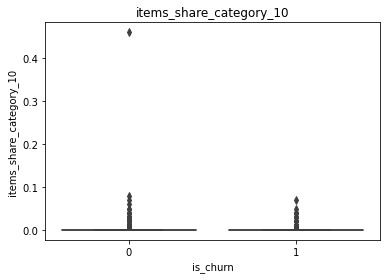

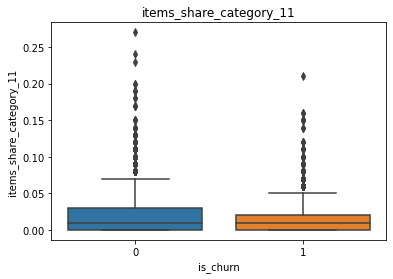

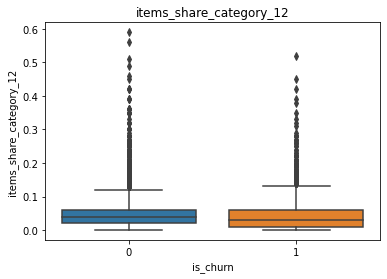

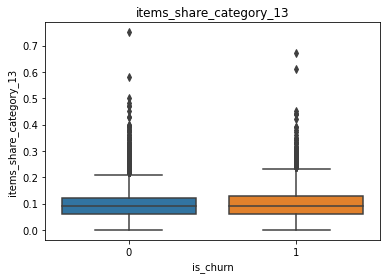

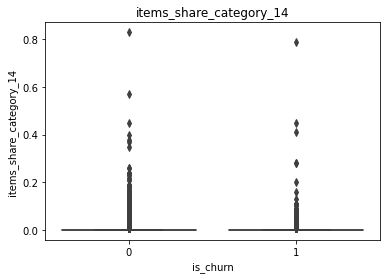

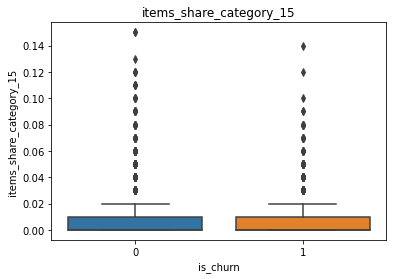

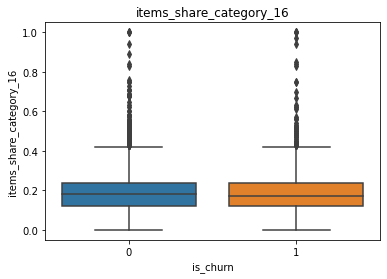

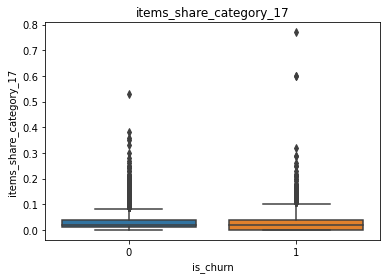

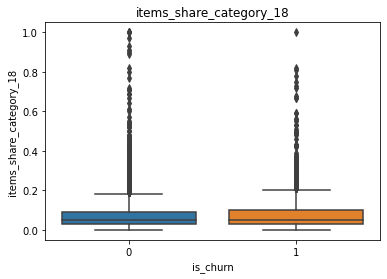

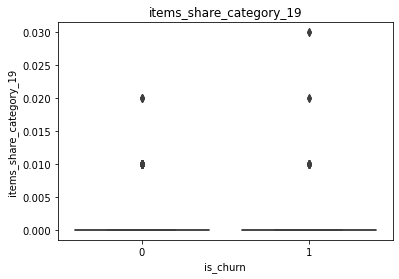

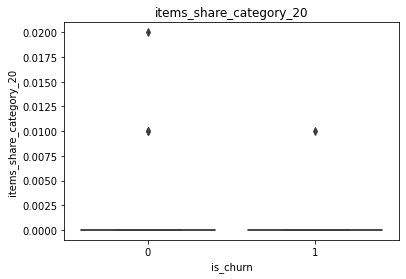

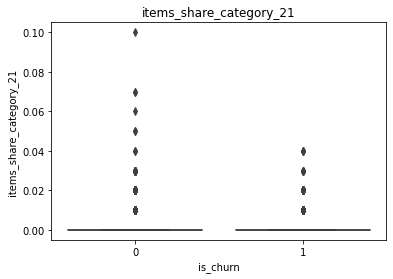

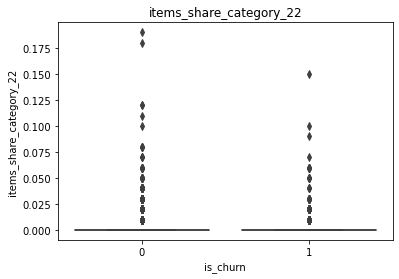

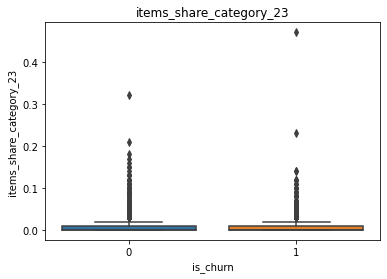

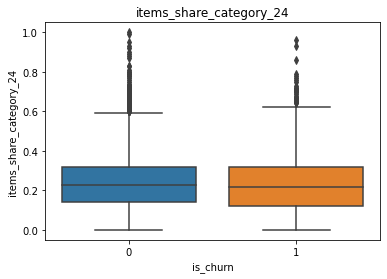

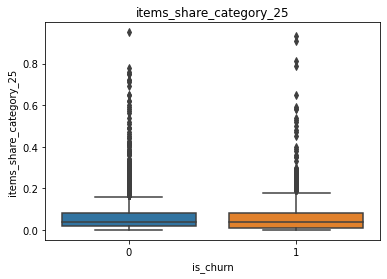

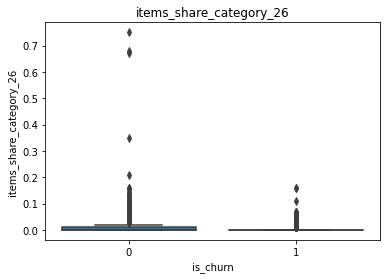

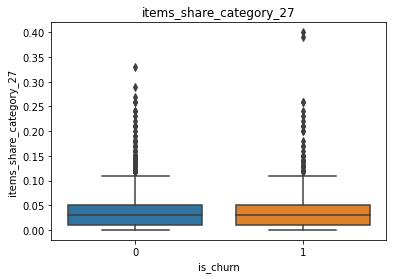

In [31]:
for feature in df_train.columns:
    if feature != 'is_churn':
        sn.boxplot(x ='is_churn', y = feature, data = df_train)
        plt.title(feature)
        plt.show()

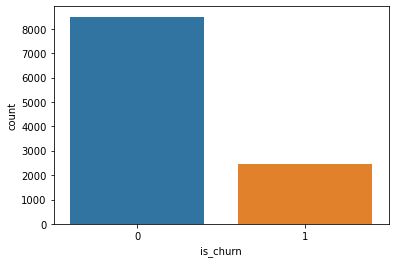

In [32]:
sn.countplot(x = 'is_churn', data = df_train)
plt.show()

### Running logistic regression to see the weights assigned to features

AxesSubplot(0.125,0.125;0.775x0.755)


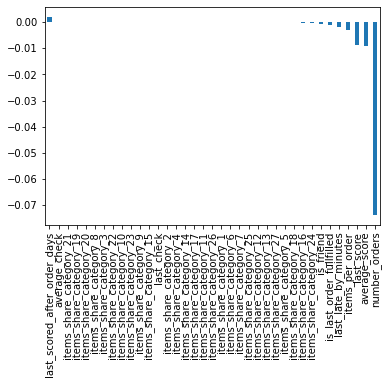

In [36]:
#X_train_items = X_train[items_share_category]
#X_test_items = X_test[items_share_category]

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

weights = pd.Series(model.coef_[0],
                 index=X_train.columns.values)
print (weights.sort_values(ascending = False)[:].plot(kind='bar'))

### Running random forest to extract feature importance

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.7765617875056999


<AxesSubplot:>

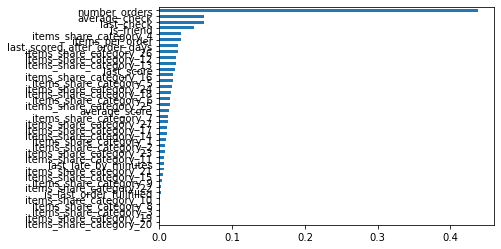

In [38]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X_train.columns.values)
weights.sort_values()[-50:].plot(kind = 'barh')

### Plotting the correlation between features and churn rate

<AxesSubplot:>

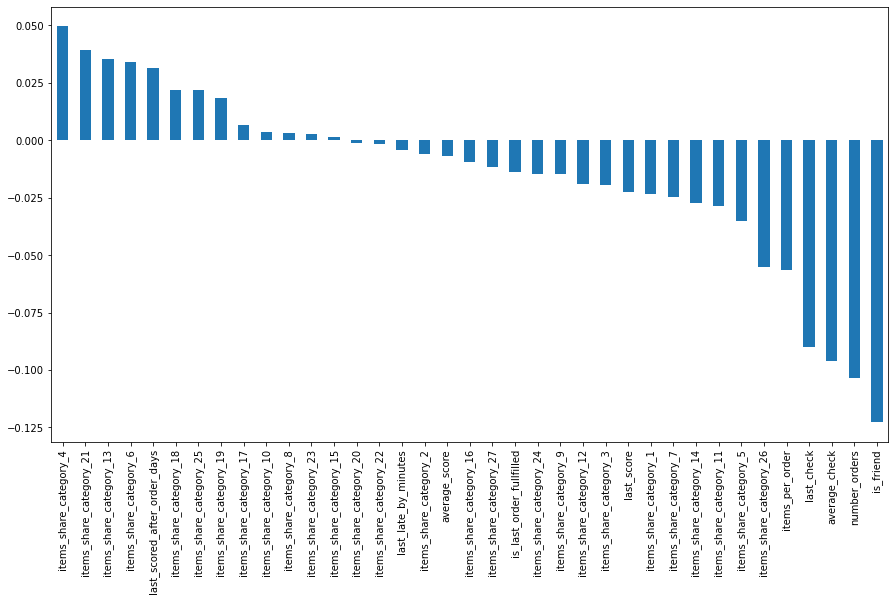

In [39]:
df_dummies = pd.get_dummies(df_train)#(df_train.drop(columns = ['last_score', 'last_scored_after_order_days', 'client_id']))
plt.figure(figsize=(15,8))
df_dummies.corr()['is_churn'][:-1].sort_values(ascending = False).plot(kind='bar')

### So far, basic analysis allows us to see which features contribute to the churn rate. It is interesting to mention that there are particular item categories that correlate with churn rate - category 4 is one of the weaker ones and contributes to clients leaving more often, while category 26 shows that the company is probably a leader in the domain, resulting in retaining users for longer periods of time.

# Running predictions with XGBoost

In [40]:
from xgboost import XGBClassifier
clf = XGBClassifier(max_depth=10, n_estimators=200, colsample_bytree=0.7, 
                        subsample=0.8, nthread=10, learning_rate=0.01)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy: ')
print('{}'.format(accuracy_score(y_test, y_pred)))
print('Classification report: ')
print('{}'.format(classification_report(y_test, y_pred)))
print('Confusion Matrix')
print('{}'.format(confusion_matrix(y_test, y_pred)))
print('Cohen kappa score: ')
print('{}'.format(cohen_kappa_score(y_test, y_pred)))

Accuracy: 
0.7738258093935249
Classification report: 
              precision    recall  f1-score   support

           0       0.78      0.98      0.87      1703
           1       0.44      0.04      0.08       490

    accuracy                           0.77      2193
   macro avg       0.61      0.51      0.48      2193
weighted avg       0.71      0.77      0.69      2193

Confusion Matrix
[[1675   28]
 [ 468   22]]
Cohen kappa score: 
0.04183506280720917


In [203]:
df = pd.DataFrame({'client_id' : test_ids, 'is_churn' : predictions})
df.to_csv("submission_xgboost.csv", index = False)

# Catboost

In [42]:
from catboost import CatBoostClassifier, Pool, cv

X = df_train.drop(columns = ['is_churn'])#, 'average_score', 'last_score', 'last_scored_after_order_days',])
y = df_train['is_churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

training = Pool(X_train, y_train)
testing = Pool(X_test, y_test)

model = CatBoostClassifier()

model.fit(training, eval_set = (X_test, y_test))

Learning rate set to 0.053321
0:	learn: 0.6690231	test: 0.6688473	best: 0.6688473 (0)	total: 57.9ms	remaining: 57.8s
1:	learn: 0.6482329	test: 0.6477065	best: 0.6477065 (1)	total: 61.7ms	remaining: 30.8s
2:	learn: 0.6276884	test: 0.6272411	best: 0.6272411 (2)	total: 64.8ms	remaining: 21.5s
3:	learn: 0.6110774	test: 0.6104517	best: 0.6104517 (3)	total: 68.1ms	remaining: 16.9s
4:	learn: 0.5960791	test: 0.5954813	best: 0.5954813 (4)	total: 70.8ms	remaining: 14.1s
5:	learn: 0.5824927	test: 0.5819200	best: 0.5819200 (5)	total: 73.6ms	remaining: 12.2s
6:	learn: 0.5710954	test: 0.5704129	best: 0.5704129 (6)	total: 76.3ms	remaining: 10.8s
7:	learn: 0.5597218	test: 0.5586803	best: 0.5586803 (7)	total: 79ms	remaining: 9.8s
8:	learn: 0.5501721	test: 0.5490243	best: 0.5490243 (8)	total: 81.9ms	remaining: 9.02s
9:	learn: 0.5418559	test: 0.5407313	best: 0.5407313 (9)	total: 85ms	remaining: 8.41s
10:	learn: 0.5346309	test: 0.5334155	best: 0.5334155 (10)	total: 87.6ms	remaining: 7.87s
11:	learn: 0.528

In [68]:
params = {    
    'loss_function': 'Logloss',
    'iterations': 100,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}
cv(params = params, pool = training, fold_count = 5)

Training on fold [0/5]
0:	learn: 0.5274931	test: 0.5294779	best: 0.5294779 (0)	total: 5.63ms	remaining: 557ms
1:	learn: 0.4899169	test: 0.4938978	best: 0.4938978 (1)	total: 9.54ms	remaining: 468ms
2:	learn: 0.4728786	test: 0.4806890	best: 0.4806890 (2)	total: 13.9ms	remaining: 451ms
3:	learn: 0.4688196	test: 0.4804141	best: 0.4804141 (3)	total: 18.4ms	remaining: 441ms
4:	learn: 0.4624320	test: 0.4796294	best: 0.4796294 (4)	total: 22.7ms	remaining: 431ms
5:	learn: 0.4606124	test: 0.4788051	best: 0.4788051 (5)	total: 26.6ms	remaining: 417ms
6:	learn: 0.4581284	test: 0.4790885	best: 0.4788051 (5)	total: 31.1ms	remaining: 414ms
7:	learn: 0.4558195	test: 0.4795263	best: 0.4788051 (5)	total: 35.1ms	remaining: 403ms
8:	learn: 0.4539020	test: 0.4808478	best: 0.4788051 (5)	total: 39.3ms	remaining: 398ms
9:	learn: 0.4511593	test: 0.4809509	best: 0.4788051 (5)	total: 43.2ms	remaining: 388ms
10:	learn: 0.4500023	test: 0.4805527	best: 0.4788051 (5)	total: 47.2ms	remaining: 382ms
11:	learn: 0.447136

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.534012,0.006594,0.528953,0.001504,0.687490,0.022839
1,1,0.497051,0.006857,0.490169,0.001505,0.707587,0.018951
2,2,0.482524,0.006856,0.473301,0.001345,0.721040,0.016798
3,3,0.481997,0.006277,0.468130,0.001924,0.719746,0.015122
4,4,0.480257,0.007834,0.463594,0.001901,0.720915,0.016512
...,...,...,...,...,...,...,...
95,95,0.547639,0.015263,0.282114,0.004777,0.682273,0.014717
96,96,0.548578,0.015013,0.280605,0.005093,0.681668,0.014907
97,97,0.548826,0.015359,0.279501,0.005047,0.682053,0.015108
98,98,0.550213,0.016163,0.278057,0.005477,0.680943,0.015546


In [69]:
X_train

,average_check,number_orders,average_score,items_per_order,is_friend,last_check,last_score,last_scored_after_order_days,last_late_by_minutes,is_last_order_fullfilled,max_cat
6187,41300,7,NaN,13.4286,0,7324.0,NaN,NaN,47,0,0.36
9360,27300,60,10.0000,6.2333,0,7480.0,NaN,NaN,0,1,0.27
6500,52700,8,10.0000,13.6250,0,17500.0,NaN,NaN,0,1,0.23
1550,41500,9,10.0000,15.2222,0,7266.0,NaN,NaN,0,1,0.36
1009,59300,10,10.0000,18.6000,0,5537.0,10.0,2.0,0,1,0.22
...,...,...,...,...,...,...,...,...,...,...,...
5734,59200,49,10.0000,16.4286,0,7290.0,NaN,NaN,0,1,0.23
5191,25000,6,8.8000,7.3333,0,7508.0,NaN,NaN,0,1,0.30
5390,83900,25,10.0000,25.9200,1,28487.0,NaN,NaN,0,1,0.22
860,46200,23,9.9000,15.3913,1,28812.0,10.0,7.0,30,1,0.23


In [60]:
model.get_object_importance(testing, training)

([7857,
  5504,
  1675,
  7178,
  7148,
  6582,
  4774,
  4838,
  4404,
  7460,
  622,
  599,
  4608,
  1552,
  2296,
  3994,
  5071,
  1203,
  4743,
  8218,
  7159,
  2354,
  6525,
  3787,
  4015,
  7272,
  2327,
  6842,
  2927,
  6896,
  7703,
  2631,
  7525,
  614,
  5425,
  8101,
  1033,
  493,
  2253,
  4701,
  4537,
  5900,
  7447,
  6873,
  2649,
  2531,
  1532,
  1873,
  6763,
  3950,
  3297,
  4289,
  851,
  6623,
  4087,
  7752,
  3199,
  4477,
  6575,
  1476,
  1781,
  5194,
  4364,
  3598,
  5050,
  5199,
  2431,
  7022,
  1522,
  3863,
  2116,
  1136,
  86,
  6809,
  4141,
  2784,
  4730,
  3551,
  5806,
  4606,
  2191,
  7815,
  7942,
  5118,
  7512,
  3762,
  2274,
  4946,
  1963,
  6441,
  4208,
  416,
  4800,
  6967,
  2196,
  3974,
  7118,
  251,
  618,
  4135,
  3906,
  2403,
  5734,
  2752,
  1538,
  3624,
  1372,
  6928,
  6666,
  4879,
  1448,
  4786,
  477,
  2792,
  6612,
  4855,
  7984,
  5511,
  3706,
  5975,
  6092,
  1403,
  7324,
  6691,
  8047,
  3344,
  1

In [292]:
model.get_best_score()

{'learn': {'Logloss': 0.2208274190457194},
 'validation': {'Logloss': 0.46120286022613916}}

In [294]:
df = pd.DataFrame({'client_id' : test_ids, 'is_churn' : predictions})
df.to_csv("submission_catboost.csv", index = False)

# At this point we got desperate, so we trained a neural net

In [542]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
#X_val = sc.fit_transform(X_val)
test = sc.fit_transform(test)
y = np.array(y)
#y_val = np.array(y_val)

In [543]:
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length
trainset = dataset(X,y)
#DataLoader
trainloader = DataLoader(trainset,batch_size=64,shuffle=False)

In [544]:
from torch import nn
from torch.nn import functional as F
class Net(nn.Module):
    def __init__(self,input_shape):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,37)
        self.fc2 = nn.Linear(37,64)
        self.fc3 = nn.Linear(64,1)
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [545]:
#hyper parameters
learning_rate = 0.01
epochs = 1000
# Model , Optimizer, Loss
model = Net(input_shape=X.shape[1])
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = nn.BCELoss()

In [548]:
#forward loop
losses = []
accur = []
for i in range(epochs):
    for j,(x_train,y_train) in enumerate(trainloader):
    
        #calculate output
        output = model(x_train)

        #calculate loss
        loss = loss_fn(output,y_train.reshape(-1,1))

        #accuracy
        predicted = model(torch.tensor(X,dtype=torch.float32))
        acc = (predicted.reshape(-1).detach().numpy().round() == y).mean()
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i%50 == 0:
        losses.append(loss)
        accur.append(acc)
        print("epoch {}\tloss : {}\t accuracy : {}".format(i,loss,acc))


epoch 0	loss : 0.5152124762535095	 accuracy : 0.7747673782156541
epoch 50	loss : 0.3785662353038788	 accuracy : 0.7758620689655172
epoch 100	loss : 0.36025452613830566	 accuracy : 0.7811530742565226
epoch 150	loss : 0.28712379932403564	 accuracy : 0.789636927567962
epoch 200	loss : 0.2474902719259262	 accuracy : 0.8003101623791279
epoch 250	loss : 0.2161165028810501	 accuracy : 0.8053274949826674
epoch 300	loss : 0.19287970662117004	 accuracy : 0.8121693121693122
epoch 350	loss : 0.17306484282016754	 accuracy : 0.8173690932311622
epoch 400	loss : 0.1553725153207779	 accuracy : 0.8210180623973727
epoch 450	loss : 0.14464609324932098	 accuracy : 0.827677431125707
epoch 500	loss : 0.12607914209365845	 accuracy : 0.8312351760627623
epoch 550	loss : 0.11502424627542496	 accuracy : 0.8336070060207992
epoch 600	loss : 0.1070735976099968	 accuracy : 0.8374384236453202
epoch 650	loss : 0.09990162402391434	 accuracy : 0.8434592227695676
epoch 700	loss : 0.09027642011642456	 accuracy : 0.84875022

In [468]:
predictions1 = []
for i in list(predictions):
    predictions1.append(int(i))

In [469]:
from sklearn.metrics import f1_score

y_pred = model(torch.tensor(X,dtype=torch.float32)).reshape(-1).detach().numpy().round()
y_true = y

f1_score(y_true, y_pred, average='weighted')

0.8944522238351089

In [470]:
df = pd.DataFrame({'client_id' : test_ids, 'is_churn' : predictions1})
df.to_csv("submission_nn.csv", index = False)